In [1125]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import torch
import data_loader
from data_loader import *
from torch_geometric.nn import SAGEConv
import metrics
from metrics import *
from utils import *
device = 'cuda:0'

In [1126]:
class SAGE(nn.Module):
    def __init__(self, ndim, activation, dropout, hid_dim=32):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(ndim, hid_dim))
        self.layers.append(SAGEConv(hid_dim, hid_dim))
        self.dropout = nn.Dropout(p=dropout)
        self.activation = activation

    def forward(self, g, nfeats, extract_features=False):
        if extract_features:
            features = []
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            if 'net_upu' in g.etypes:
                etype = 'net_upu'
                nfeats = layer(nfeats, g.adjacency_matrix(etype=etype).coalesce().indices().to(device))
            else:
                nfeats = layer(nfeats, g.adjacency_matrix().coalesce().indices().to(device))
            if extract_features:
                features.append(nfeats)
            nfeats = self.activation(nfeats)
        if extract_features:
            return nfeats, features
        else:
            return nfeats

In [1127]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features, out_classes)

    def forward(self, graph, h):
        with graph.local_scope():
            return self.W(h)

In [1128]:
class Model(nn.Module):
    def __init__(self, ndim, ndim_s, ndim_t, activation, dropout, hid_dim=128, out_classes_s=2, out_classes_t=2, transfer_mode=False):
        super().__init__()
        self.transfer_mode = transfer_mode
        self.proj_s = nn.Linear(ndim_s, ndim)
        self.proj_t = nn.Linear(ndim_t, ndim)
        self.gnn = SAGE(ndim, activation, dropout, hid_dim=hid_dim)
        self.pred = MLPPredictor(hid_dim, out_classes_s)

    def _transfer(self, transfer_mode):
        self.transfer_mode = transfer_mode

    def forward(self, g, extract_features=False):
        if self.transfer_mode:
            g.ndata['h_proj'] = self.proj_t(g.ndata['h'])
        else:
            g.ndata['h_proj'] = self.proj_s(g.ndata['h'])
        nfeats = g.ndata['h_proj']

        if extract_features:
            h, features = self.gnn(g, nfeats, extract_features)
            # features.append(nfeats)
        else:
            h = self.gnn(g, nfeats)
        pred = self.pred(g, h)
        if extract_features:
            return pred, torch.cat(features, dim=1)
            # return pred, features[-1]
        else:
            return pred

In [1129]:
def reg_edge(emb, adj):
    emb = emb / torch.norm(emb, dim=-1, keepdim=True)
    sim_u_u = torch.mm(emb, emb.T)
    adj_inverse = (1 - adj)
    sim_u_u = sim_u_u * adj_inverse
    sim_u_u_no_diag = torch.sum(sim_u_u, 1)
    row_sum = torch.sum(adj_inverse, 1)
    r_inv = torch.pow(row_sum, -1)
    r_inv[torch.isinf(r_inv)] = 0.
    sim_u_u_no_diag = sim_u_u_no_diag * r_inv
    loss_reg = torch.sum(sim_u_u_no_diag)
    return loss_reg


def max_message(feature, adj_matrix):
    feature = feature / torch.norm(feature, dim=-1, keepdim=True)
    sim_matrix = torch.mm(feature, feature.T)
    sim_matrix = torch.squeeze(sim_matrix) * adj_matrix
    sim_matrix[torch.isinf(sim_matrix)] = 0
    sim_matrix[torch.isnan(sim_matrix)] = 0
    row_sum = torch.sum(adj_matrix, 0)
    r_inv = torch.pow(row_sum, -1).flatten()
    r_inv[torch.isinf(r_inv)] = 0.
    message = torch.sum(sim_matrix, 1)
    message = message * r_inv
    return - torch.sum(message), message


def inference(feature, adj_matrix):
    feature = feature / torch.norm(feature, dim=-1, keepdim=True)
    sim_matrix = torch.mm(feature, feature.T)
    sim_matrix = torch.squeeze(sim_matrix) * adj_matrix
    row_sum = torch.sum(adj_matrix, 0)
    r_inv = torch.pow(row_sum, -1).flatten()
    r_inv[torch.isinf(r_inv)] = 0.
    message = torch.sum(sim_matrix, 1)
    message = message * r_inv
    return message


def normalize_score(ano_score):
    ano_score = ((ano_score - np.min(ano_score)) / (
            np.max(ano_score) - np.min(ano_score)))
    return ano_score


def normalize_adj_tensor(raw_adj):
    adj = raw_adj
    row_sum = torch.sum(adj, 0)
    r_inv = torch.pow(row_sum, -0.5).flatten()
    r_inv[torch.isinf(r_inv)] = 0.
    adj = torch.mm(adj, torch.diag_embed(r_inv))
    adj = torch.mm(torch.diag_embed(r_inv), adj)
    return adj

# GADT3


In [1773]:
ndim_common = 40
ndim_s = 64
ndim_t = 25
hid_dim = 128

In [1774]:
# Load and preprocess data
from scipy import sparse
from sklearn.decomposition import PCA
dataset_src = 'Amazon' # 'BlogCatalog'  'ACM'  'Amazon' 'Facebook'  'Reddit'  'YelpChi'
adj, features,  ano_label, str_ano_label, attr_ano_label = load_mat(dataset_src)

num_nodes = adj.shape[0]
sample_size = int(num_nodes * Source_Percentage)
sample_indices = np.random.choice(num_nodes, sample_size, replace=False)

# Subsample the adjacency matrix
adj = adj[sample_indices][:, sample_indices]

# Subsample the features
features = features[sample_indices]

# Subsample the labels
ano_label = ano_label[sample_indices]

if dataset_src in ['Amazon', 'YelpChi', 'Amazon-all', 'YelpChi-all']:
    features, _ = preprocess_features(features)
    raw_features = features
else:
    raw_features = features.todense()
    features = raw_features


dgl_graph_src = adj_to_dgl_graph(adj)
nb_nodes = features.shape[0]
ft_size = features.shape[1]
raw_adj = adj
raw_adj = (raw_adj + sp.eye(adj.shape[0])).todense()
adj = (adj + sp.eye(adj.shape[0])).todense()
raw_features = torch.FloatTensor(raw_features[np.newaxis])
features = torch.FloatTensor(features[np.newaxis])
adj = torch.FloatTensor(adj[np.newaxis])
raw_adj = torch.FloatTensor(raw_adj[np.newaxis])

In [1775]:
p = 0.2
dataset_src = dataset_src
G = dgl_graph_src

num_classes = 2
G.ndata['feature'] = np.squeeze(features)
G.ndata['train_mask'] = th.rand(len(G.ndata['feature']))>p
scaler_all = StandardScaler()
scaler_all.fit(G.ndata['feature'][G.ndata['train_mask']])
G.ndata['h'] = th.tensor(scaler_all.transform(G.ndata['feature']), dtype=th.float32)
G.ndata['Label'] = torch.from_numpy(ano_label)

G_s = deepcopy(G)
G = G.to(device)

In [2]:
extract_features = True

lmbd = 0.001
lmbd_reg = 0.1

class_weights = [1,1]

class_weights = th.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

node_features = G.ndata['h']
node_label = G.ndata['Label']
train_mask = G.ndata['train_mask']

node_label = node_label.type(torch.LongTensor)

node_label = node_label.to(device)
model = Model(ndim_common, G.ndata['h'].shape[1], ndim_t, F.relu, 0.7, hid_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

best_auc = 0
best_ap = 0

if 'net_upu' in G.etypes:
    etype = 'net_upu'
else:
    etype = None

for epoch in range(1,80):
    model.train()

    opt.zero_grad()
    pred, s_f = model(G, extract_features=extract_features)
    loss = criterion(pred[train_mask], node_label[train_mask])
    
    loss_tam, _ = max_message(s_f, G.adjacency_matrix(etype = etype).to_dense().to(device))
    loss_reg = reg_edge(s_f, G.adjacency_matrix(etype = etype).to_dense().to(device))
    loss.backward()
    opt.step()
    model.eval()
    if epoch % 1 == 0:
        _, s_f = model(G, extract_features=extract_features)
        pred = inference(s_f, G.adjacency_matrix(etype = etype).to_dense().to(device))
        pred = np.array(torch.squeeze(pred).cpu().detach())
        pred = 1 - normalize_score(pred)
        train_mask = train_mask.cpu()
        tmp_auc = roc_auc_score(node_label[~train_mask].cpu(), pred[~train_mask])
        tmp_ap = average_precision_score(node_label[~train_mask].cpu(), pred[~train_mask], average='macro', pos_label=1, sample_weight=None)
        print(f"epoch:{epoch}, auc:{np.round(100*tmp_auc,2)}, AP:{np.round(100*tmp_ap,2)}")


# Target 

In [1779]:
# Load and preprocess data
dataset = 'Amazon' # 'BlogCatalog'  'ACM'  'Amazon' 'Facebook'  'Reddit'  'YelpChi'
adj, features,  ano_label, str_ano_label, attr_ano_label = load_mat(dataset)

if dataset in ['Amazon', 'YelpChi', 'Amazon-all', 'YelpChi-all']:
    features, _ = preprocess_features(features)
    raw_features = features

else:
    raw_features = features.todense()
    features = raw_features

dgl_graph = adj_to_dgl_graph(adj)
nb_nodes = features.shape[0]
ft_size = features.shape[1]
raw_adj = adj
raw_adj = (raw_adj + sp.eye(adj.shape[0])).todense()
adj = (adj + sp.eye(adj.shape[0])).todense()
raw_features = torch.FloatTensor(raw_features[np.newaxis])
features = torch.FloatTensor(features[np.newaxis])
adj = torch.FloatTensor(adj[np.newaxis])
raw_adj = torch.FloatTensor(raw_adj[np.newaxis])

In [1]:
extract_features = True
p = 0
print(f'train percent:{1-p}')

dataset = dataset
G = dgl_graph
num_classes = 2
G.ndata['feature'] = np.squeeze(features)
G.ndata['train_mask'] = th.rand(len(G.ndata['feature']))>p
scaler_all = StandardScaler()
scaler_all.fit(G.ndata['feature'][G.ndata['train_mask']])
G.ndata['h'] = th.tensor(scaler_all.transform(G.ndata['feature']), dtype=th.float32)
G.ndata['Label'] = torch.from_numpy(ano_label)
G = G.to(device)

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

node_features = G.ndata['h']
node_label = G.ndata['Label']
train_mask = G.ndata['train_mask']
len_train = int((1-p)*len(train_mask))
print(len_train)

model_t = copy.deepcopy(model)
model_t._transfer(True)
model_t.proj_s.requires_grad_(False)
model_t.proj_t.requires_grad_(True)
model_t.gnn.layers[0].requires_grad_(False)
model_t.gnn.layers[1].requires_grad_(False)
model_t.pred.requires_grad_(False)


opt = torch.optim.Adam(model_t.parameters(), lr=0.007)
best_f1 = 0
best_auc = 0
mmd = []
auc_list = []
ap_list = []
for epoch in range(1,50):
    opt.zero_grad()
    model_t.train()
    pred, t_f = model_t(G, extract_features=extract_features)
    loss_tam, _ = max_message(t_f, G.adjacency_matrix().to_dense().to(device))
    loss_reg = reg_edge(t_f, G.adjacency_matrix().to_dense().to(device))
    loss = lmbd*(loss_tam + lmbd_reg*loss_reg)
    
    loss.backward()
    opt.step()
    model_t.eval()
    if epoch % 1 == 0:
        _, t_f = model_t(G, extract_features=extract_features)
        pred = inference(t_f, G.adjacency_matrix().to_dense().to(device))
        pred = np.array(torch.squeeze(pred).cpu().detach())
        pred = 1 - normalize_score(pred)
        tmp_auc = roc_auc_score(node_label.cpu(), pred)
        tmp_ap = average_precision_score(node_label.cpu(), pred, average='macro', pos_label=1, sample_weight=None)
        print(f"epoch:{epoch}, auc:{np.round(100*tmp_auc,2)}, AP:{np.round(100*tmp_ap,2)}")
        _, target_features = model_t(G, extract_features=extract_features)
        target_features = target_features.cpu().detach().numpy()
        mmd.append(mmd_rbf(source_features, target_features))
        auc_list.append(tmp_auc)
        ap_list.append(tmp_ap)
print(f"final, auc:{np.round(100*tmp_auc,2)}, AP:{np.round(100*tmp_ap,2)}")

# Affinity score

In [404]:
import dgl
import torch

def similar_neighbor_ratio(g, labels):
    # Ensure labels is a tensor
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    
    # Get adjacency matrix
    adj = g.adj().to_dense()
    
    # Compute total neighbors per node
    total_neighbors = adj.sum(dim=1)
    
    # Compute similar neighbors
    similar_neighbors = torch.zeros_like(total_neighbors)
    for i in range(g.number_of_nodes()):
        neighbors = adj[i].nonzero().squeeze()
        similar_neighbors[i] = (labels[neighbors] == labels[i]).sum().float()
    
    # Calculate ratios, avoiding division by zero
    ratios = torch.where(total_neighbors != 0, 
                         similar_neighbors / total_neighbors, 
                         torch.zeros_like(total_neighbors))
    
    return {int(i): float(ratio) for i, ratio in enumerate(ratios)}


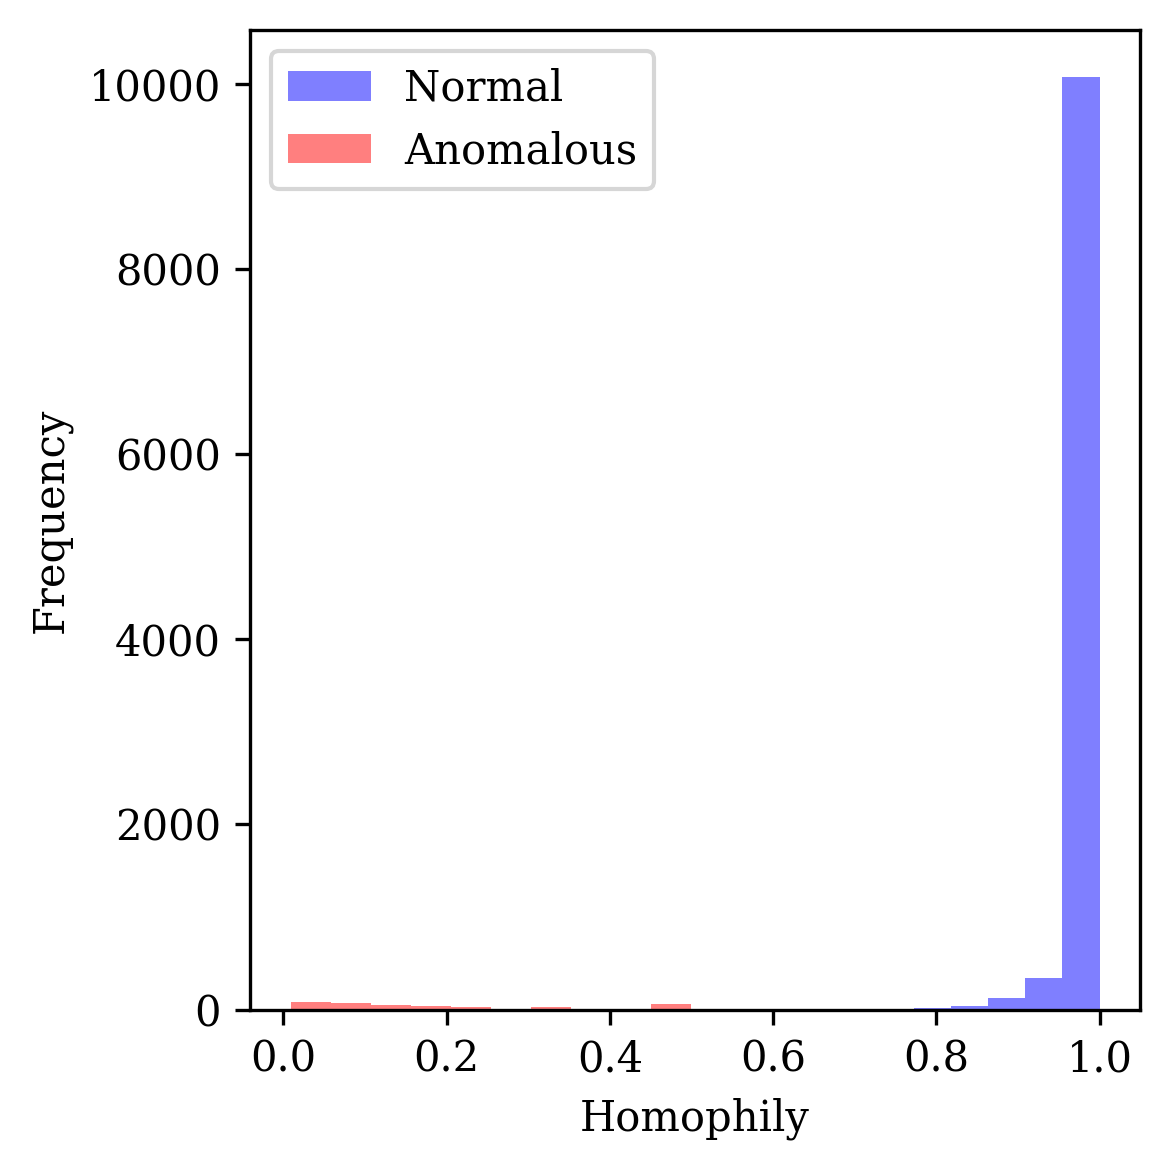

In [446]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use default matplotlib fonts
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Bitstream Vera Serif", "Computer Modern Roman", "New Century Schoolbook", "Century Schoolbook L", "Utopia", "ITC Bookman", "Bookman", "Nimbus Roman No9 L", "Times New Roman", "Times", "Palatino", "Charter", "serif"],
    "mathtext.fontset": "dejavuserif"
})
plt.figure(figsize=(4,4))

# Separate the scores based on labels
scores_label_0 = aff_scores_2[label_s == 0]
scores_label_1 = aff_scores_2[label_s == 1]

# Plot histograms for each label
plt.hist(scores_label_0, color='blue', alpha=0.5, label='Normal')
plt.hist(scores_label_1, color='red', alpha=0.5, label='Anomalous')

plt.ylabel('Frequency')
plt.xlabel('Homophily')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.savefig(f'Node GT affinity score: {dataset_src}.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()